In [60]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import seaborn as sns
from matplotlib import pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from numba import jit

from scipy.special import comb
import scipy.optimize as optimize

%matplotlib inline

# 1. Simulated Functional Form

In this section, we explore the possible functional form: Duration = f(Price, Rate), using simulated data from BDT tree

## 1.1. Callable Bond Function

In [7]:
#return interst rate of each node
@jit
def generateBTR(r0,drift,sigma,n,year): 
    n_level = n * year
    BT = np.zeros((n_level, n_level))
    BT[0][0] = r0
    deltaT=1/n
    for i in range(1, n_level):
        BT[:, i] = BT[:, i - 1] * np.exp(drift*deltaT+sigma*np.sqrt(deltaT))
        BT[i][i] = BT[i - 1][i - 1] * np.exp(drift*deltaT-sigma*np.sqrt(deltaT))
    return BT

#return discount rate between each deltaT
@jit
def generateBT(r0,drift,sigma,n,year): 
    BTR = generateBTR(r0,drift,sigma,n,year)
    deltaT=1/n
    return np.exp(-BTR*deltaT)

@jit
def discountedValue(BT,n):
    result = BT[:n, n - 1]
    for i in np.arange(n-1,0,-1):
        result = 0.5 * (result[:-1] + result[1:]) * BT[:i, i - 1]
    return result[0]

'''
r0=current continous conpouding short rate
drift,sigma=parameters in model
n=numer of steps in year
year=matirity
cFrq=how many times of coupon payment per year
c=coupon rate
principle=face value
'''
@jit
def vanillaBond(r0,drift,sigma,n,year,cFrq,c,principle):
    BT=generateBT(r0,drift,sigma,n,year)
    price=principle*discountedValue(BT,year*n) 
    for t in np.array(range(1,cFrq*year+1))/cFrq:
        price+=(c/cFrq)*principle*discountedValue(BT,int(t*n))  
    return price

@jit
def callableBond(r0,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime):
    
    BTRt=generateBTR(r0,drift,sigma,n,callTime)
    BTt=generateBT(r0,drift,sigma,n,callTime)
    
    newR=BTRt[:, n*callTime - 1].squeeze()
    len_newR = len(newR)
    
    price=0
    count=0
    for r in newR:
        p1=min(vanillaBond(r,drift,sigma,n,year-callTime,cFrq,c,principle),callPirce)
        price+=p1*discountedValue(BTt,callTime*n)*comb(len_newR-1, count)/(2**(len(newR)-1))
        count+=1
        
    for t in np.arange(1,cFrq*callTime+1)/cFrq:
        price+=(c/cFrq)*principle*discountedValue(BTt,int(t*n))  
    return price

def ytm(price,c,principle,cFrq,year):
    
    freq = float(cFrq)
    periods = year*freq
    coupon = c*principle/cFrq
    dt = [(i+1)/freq for i in range(int(periods))]
    ytm_func = lambda y: sum([coupon/(1+y/freq)**(freq*t) for t in dt]) + principle/(1+y/freq)**(freq*year) - price
    
    return optimize.newton(ytm_func, 0.03)

## 1.2. Simulate Price and Duration

In [8]:
libor3m = pd.read_excel('libor 3m.xlsx')
libor3m.head()

,Date,US0003M Index
0,2015-05-13,0.2739
1,2015-05-14,0.2760
2,2015-05-15,0.2765
3,2015-05-18,0.2760
4,2015-05-19,0.2810


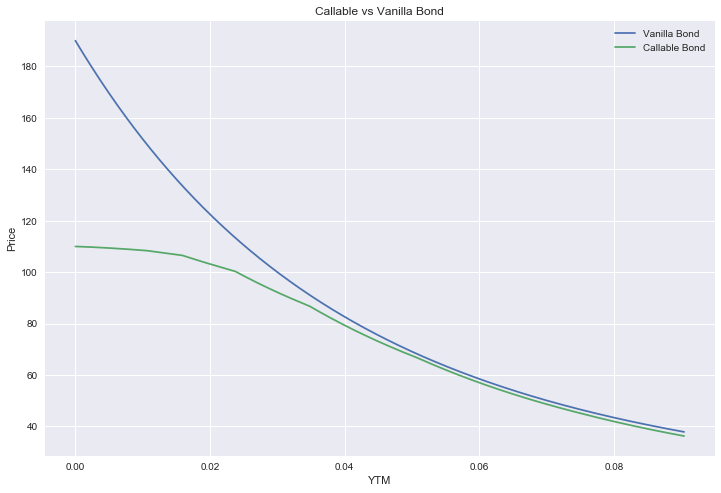

In [61]:
drift=0.01
sigma=0.4
n=2
year=30
cFrq=2
c=0.03
principle=100
callPirce=101
callTime=3
deltaR=0.01

y=[]
price=[]
priceC=[]
for r in np.arange(0,1000)*0.0001:
    p=vanillaBond(r,drift,sigma,n,year,cFrq,c,principle)
    y.append(ytm(p,c,principle,cFrq,year))
    price.append(p)
    priceC.append(callableBond(r,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime))
plt.figure(figsize=(12,8))    
plt.plot(y,price,label='Vanilla Bond') 
plt.plot(y,priceC,label='Callable Bond')
plt.title('Callable vs Vanilla Bond')
plt.xlabel('YTM')
plt.ylabel('Price')
plt.legend()
plt.show()

In [63]:
y=[]
priceC=[]
duration=[]
R=np.array(libor3m['US0003M Index'])/100
for r in R:
    p=vanillaBond(r,drift,sigma,n,year,cFrq,c,principle)
    y.append(ytm(p,c,principle,cFrq,year))
    priceC.append(callableBond(r,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime))
    duration.append((callableBond(r+deltaR,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime)-\
                    callableBond(r-deltaR,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime))/(2*deltaR))
    
duration_m =  - np.array(duration) / np.array(priceC)
#print(priceC)

### 1.2.1. Explore relationship between Price/Duration and YTM 

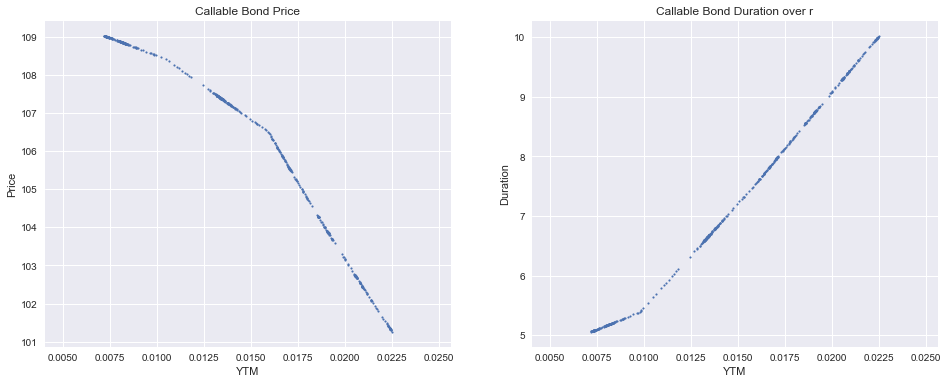

In [64]:
fig = plt.figure(figsize=(16, 6))    

ax1 = fig.add_subplot(121)
ax1.scatter(y,priceC,label='Callable Bond Price', s = 3)
ax1.set_title('Callable Bond Price')
ax1.set_xlabel('YTM')
ax1.set_ylabel('Price')

ax2 = fig.add_subplot(122)
ax2.scatter(y,duration_m,label='Callable Bond Duration over r', s = 3)
ax2.set_title('Callable Bond Duration over r')
ax2.set_xlabel('YTM')
ax2.set_ylabel('Duration')

**Issue 1: the real libor is not low enough to have the negative convexity. Test needs to be done to find the parameters that allows call option to take effect for real 3M Libor data**

### 1.2.2. Explore relationship between Duration and 3m Libor/Price

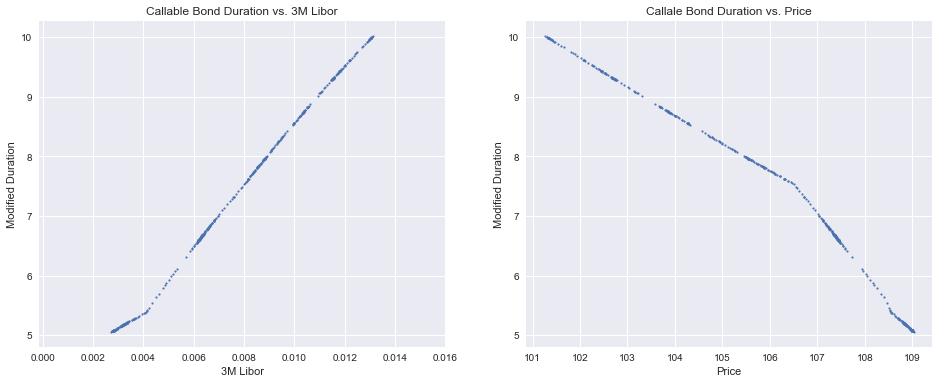

In [65]:
fig = plt.figure(figsize=(16, 6))    

ax1 = fig.add_subplot(121)
plt.scatter(np.array(R),duration_m, s = 3)
ax1.set_title('Callable Bond Duration vs. 3M Libor')
ax1.set_xlabel('3M Libor')
ax1.set_ylabel('Modified Duration')

ax2 = fig.add_subplot(122)
ax2.scatter(priceC,duration_m, s = 3)
ax2.set_title('Callale Bond Duration vs. Price')
ax2.set_xlabel('Price')
ax2.set_ylabel('Modified Duration')

Since we are exploring $Duration = f(Price, 3M Libor)$, we also plot the 3D chart

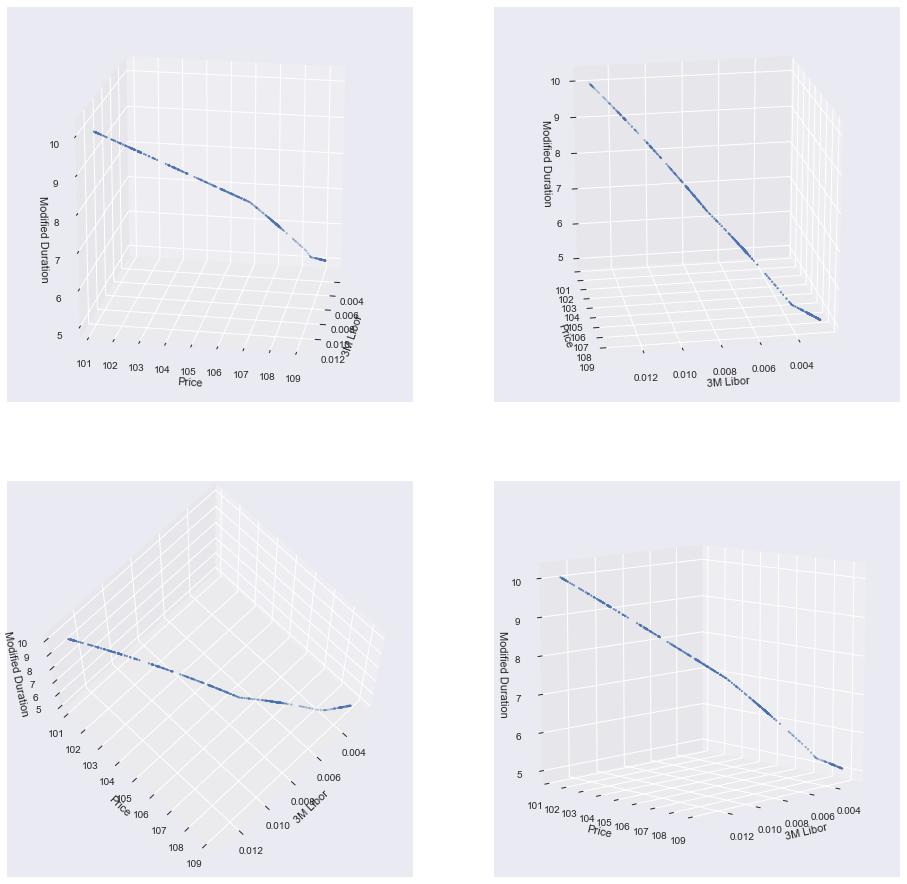

In [69]:
fig = plt.figure(figsize = (16, 16))
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(xs=R, ys=priceC, zs=duration_m, s = 3)
ax1.view_init(20, 10)
ax1.set_xlabel('3M Libor')
ax1.set_ylabel('Price')
ax1.set_zlabel('Modified Duration')

ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(xs=R, ys=priceC, zs=duration_m, s = 3)
ax2.view_init(20, 80)
ax2.set_xlabel('3M Libor')
ax2.set_ylabel('Price')
ax2.set_zlabel('Modified Duration')

ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(xs=R, ys=priceC, zs=duration_m, s = 3)
ax3.view_init(70, 45)
ax3.set_xlabel('3M Libor')
ax3.set_ylabel('Price')
ax3.set_zlabel('Modified Duration')

ax4 = fig.add_subplot(224, projection='3d')
ax4.scatter(xs=R, ys=priceC, zs=duration_m, s = 3)
ax4.view_init(10, 45)
ax4.set_xlabel('3M Libor')
ax4.set_ylabel('Price')
ax4.set_zlabel('Modified Duration')

## 1.3. Function fit

### 1.3.1. Polynomial

The plot indicates that there's a possible polynomial relationship between duration and price/rate. So we start from polynomial fit 

In [98]:
#http://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions
def poly2Var(duration,priceC,R,deg):
    X = np.hstack((R.reshape(-1,1), np.array(priceC).reshape(-1,1)))
    vector = duration
    poly = PolynomialFeatures(degree=deg)
    X_=poly.fit_transform(X)
    clf = linear_model.LinearRegression()
    clf.fit(X_, vector)
    
    #test the fit
    predict= X.copy()
    predict_ = poly.fit_transform(predict)
    return [clf.coef_,clf.predict(predict_),clf.score(predict_, vector)]

def plotData(R, priceC, duration_m, fit):
    fig = plt.figure(figsize = (16, 16))
    ax1 = fig.add_subplot(221, projection='3d')
    ax1.scatter(xs=R, ys=priceC, zs=duration_m, s = 3, c = 'red', label = 'Actual Data')
    ax1.plot(xs=R, ys=priceC, zs=fit, c = 'green', label = 'Fitted Data')
    ax1.view_init(20, 20)
    ax1.set_xlabel('3M Libor')
    ax1.set_ylabel('Price')
    ax1.set_zlabel('Modified Duration')
    ax1.legend()

    ax2 = fig.add_subplot(222, projection='3d')
    ax2.scatter(xs=R, ys=priceC, zs=duration_m, s = 3, c = 'red', label = 'Actual Data')
    ax2.plot(xs=R, ys=priceC, zs=fit, c = 'green', label = 'Fitted Data')
    ax2.view_init(20, 80)
    ax2.set_xlabel('3M Libor')
    ax2.set_ylabel('Price')
    ax2.set_zlabel('Modified Duration')
    ax2.legend()

    ax3 = fig.add_subplot(223, projection='3d')
    ax3.scatter(xs=R, ys=priceC, zs=duration_m, s = 3, c = 'red', label = 'Actual Data')
    ax3.plot(xs=R, ys=priceC, zs=fit, c = 'green', label = 'Fitted Data')
    ax3.view_init(70, 45)
    ax3.set_xlabel('3M Libor')
    ax3.set_ylabel('Price')
    ax3.set_zlabel('Modified Duration')
    ax3.legend()
    
    ax4 = fig.add_subplot(224, projection='3d')
    ax4.scatter(xs=R, ys=priceC, zs=duration_m, s = 3, c = 'red', label = 'Actual Data')
    ax4.plot(xs=R, ys=priceC, zs=fit, c = 'green', label = 'Fitted Data')
    ax4.view_init(20, 45)
    ax4.set_xlabel('3M Libor')
    ax4.set_ylabel('Price')
    ax4.set_zlabel('Modified Duration')
    ax4.legend()

#### 1.3.1.1. Order of 2 Polynomial

In [96]:
coef,fit,r2=poly2Var(duration_m,priceC,R,2)

In [18]:
r2

0.99982930334649611

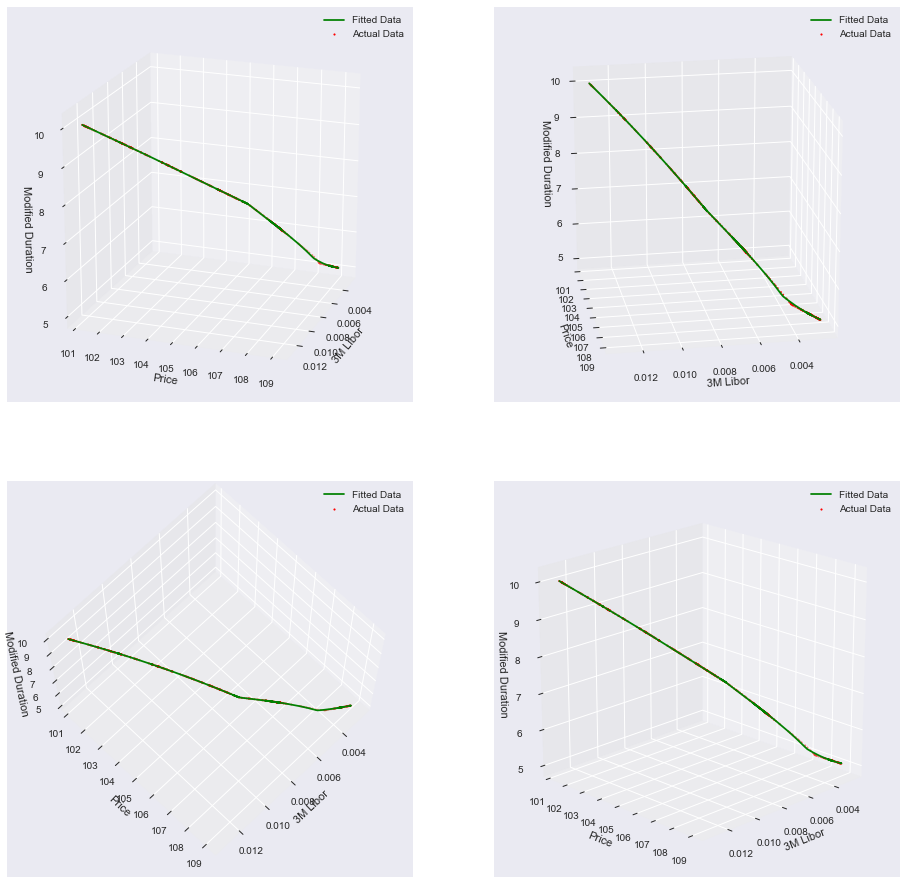

In [99]:
plotData(R, priceC, duration_m, fit)

#### 1.3.1.1. Order of 3 Polynomial

In [107]:
coef,fit,r2=poly2Var(duration_m,priceC,R,3)

In [108]:
r2

0.99998516414327487

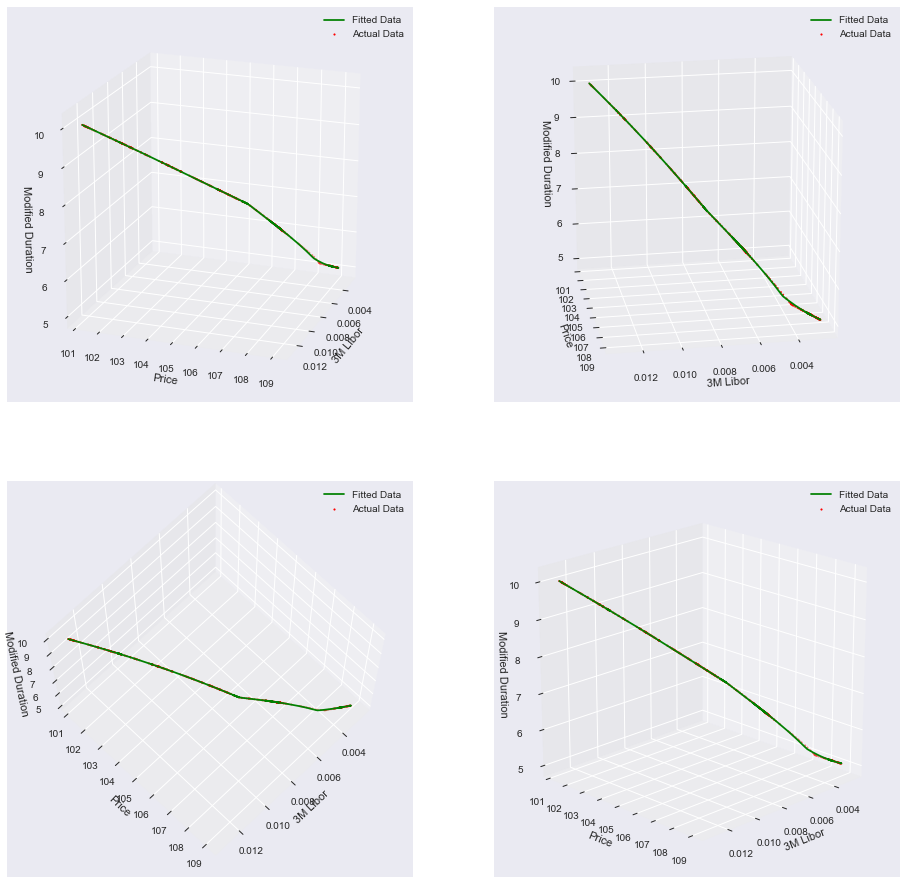

In [109]:
plotData(R, priceC, duration_m, fit)

**Observation: the polynomial can fit the data very well**

### 1.3.2. Exponential fit

Take the form of 

$$Duration = e^{poly(price, rate)}$$

#### 1.3.2.1 Order of 1 exponential fit

In [115]:
coef,fit,r2=poly2Var(np.log(duration_m),priceC,R,1)

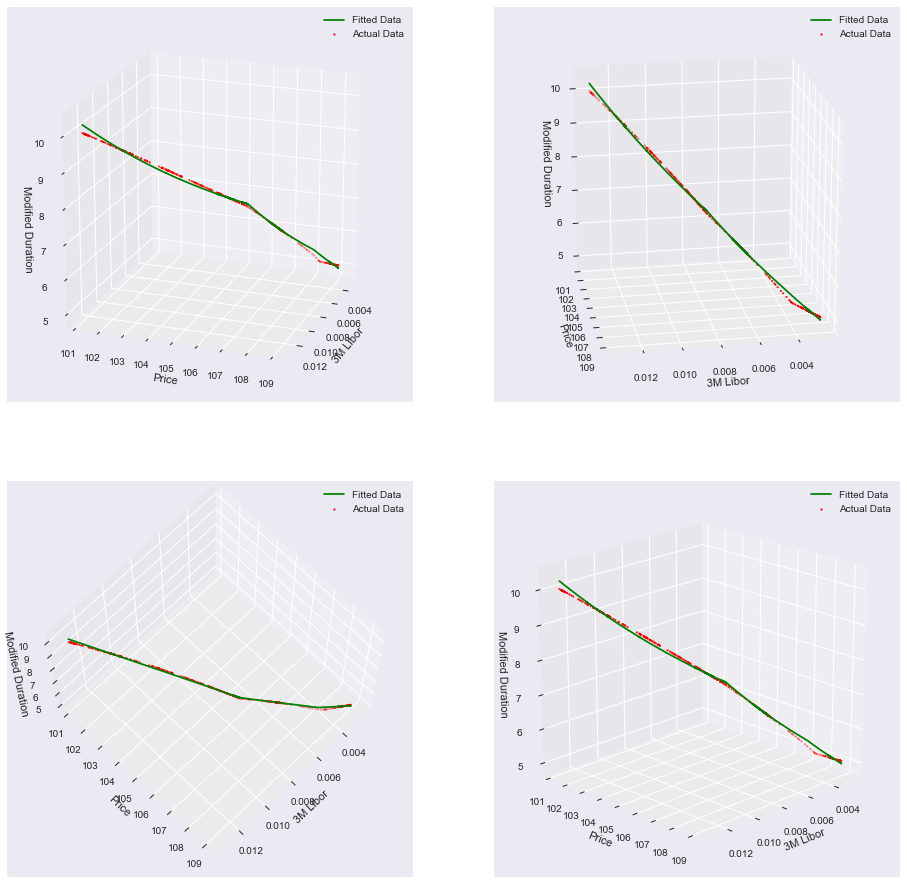

In [116]:
plotData(R, priceC, duration_m, np.exp(fit))

#### Order of 2 exponential fit

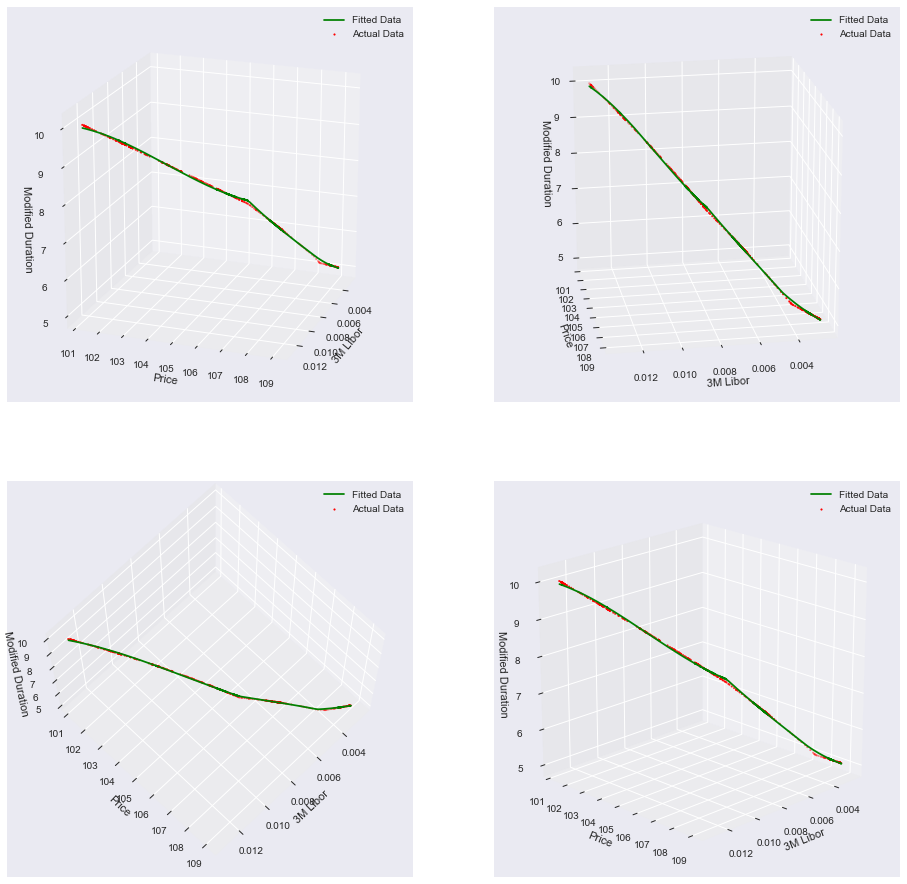

In [117]:
coef,fit,r2=poly2Var(np.log(duration_m),priceC,R,2)
plotData(R, priceC, duration_m, np.exp(fit))

**Observation: the exponential fit is not as good as polynomial fit. So we further explore the polynomial fit with train/test data set**

### 1.3.3. Train/Test Split

In [126]:
def poly2Var_TrainTestSplit(duration_train,priceC_train,R_train,priceC_test,R_test,duration_test,deg):
    X = np.hstack((R_train.reshape(-1,1), priceC_train.reshape(-1,1)))
    vector = duration_train
    poly = PolynomialFeatures(degree=deg)
    X_=poly.fit_transform(X)
    clf = linear_model.LinearRegression()
    clf.fit(X_, vector)
    
    #test the fit
    predict= np.hstack((R_test.reshape(-1,1), priceC_test.reshape(-1,1)))
    predict_ = poly.fit_transform(predict)
    return [clf.coef_,clf.predict(predict_),clf.score(predict_, duration_test)]

In [136]:
duration_m
priceCa = np.array(priceC)
Ra = np.array(R)

split_point = 355

duration_m_train = duration_m[:split_point]
duration_m_test = duration_m[split_point:]

priceCa_train = priceCa[:split_point]
priceCa_test = priceCa[split_point:]

Ra_train = Ra[:split_point]
Ra_test = Ra[split_point:]

#### 1.3.3.1. Order of 2 polynomial

In [130]:
coef,fit,r2=poly2Var_TrainTestSplit(duration_m_train,priceCa_train,Ra_train,priceCa_test,Ra_test,duration_m_test,2)

In [131]:
r2

0.92629649215539422

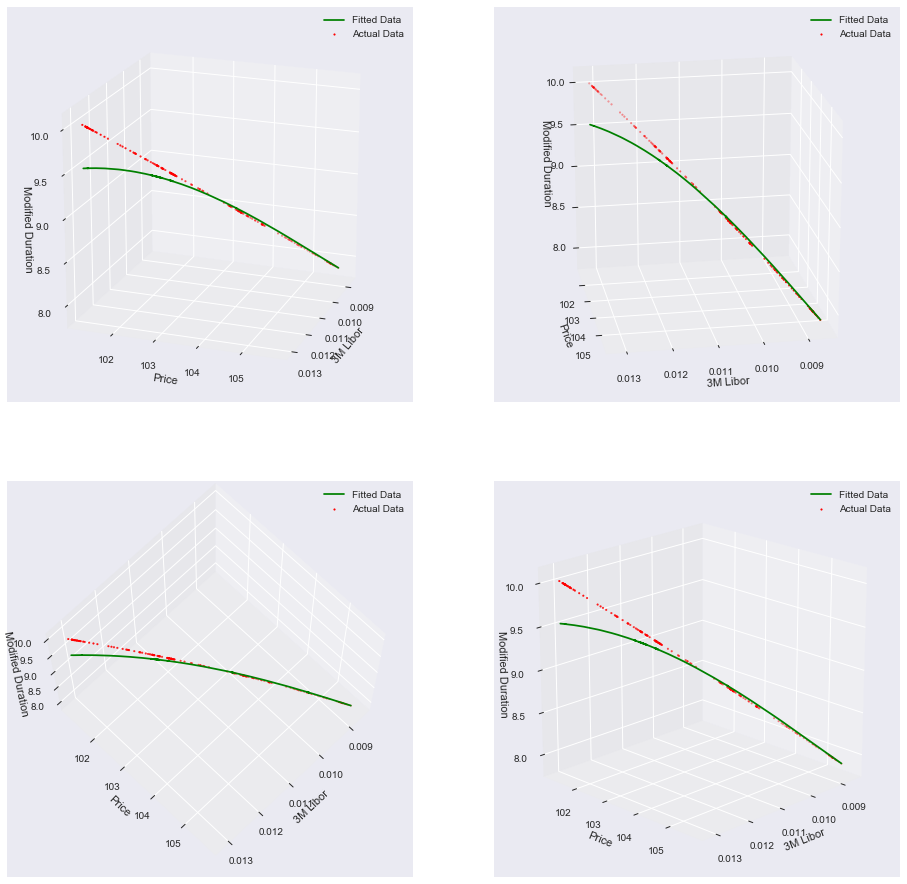

In [133]:
plotData(Ra_test, priceCa_test, duration_m_test, fit)

#### 1.3.3.2. Order of 3 polynomial

In [137]:
coef,fit,r2=poly2Var_TrainTestSplit(duration_m_train,priceCa_train,Ra_train,priceCa_test,Ra_test,duration_m_test,3)

In [138]:
r2

-563.71864523208353

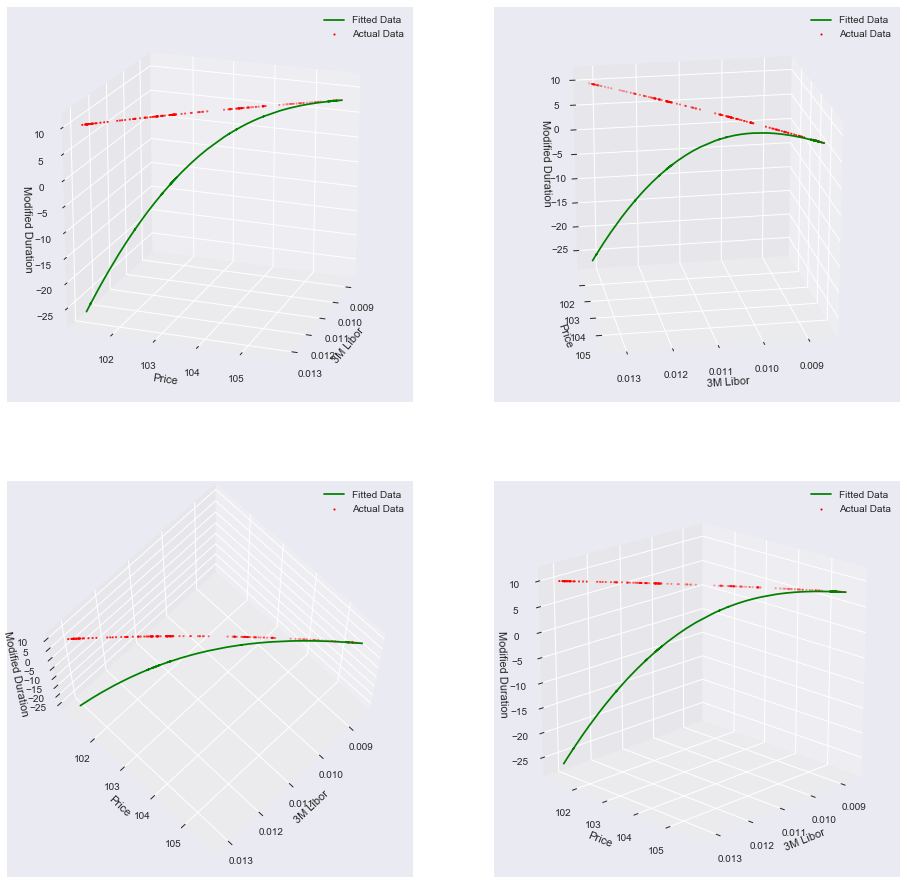

In [139]:
plotData(Ra_test, priceCa_test, duration_m_test, fit)

#### 1.3.3.3. Order of 1 exponential

In [140]:
coef,fit,r2=poly2Var_TrainTestSplit(np.log(duration_m_train),priceCa_train,Ra_train,priceCa_test,Ra_test,np.log(duration_m_test),1)

In [141]:
r2

0.56387218733554967

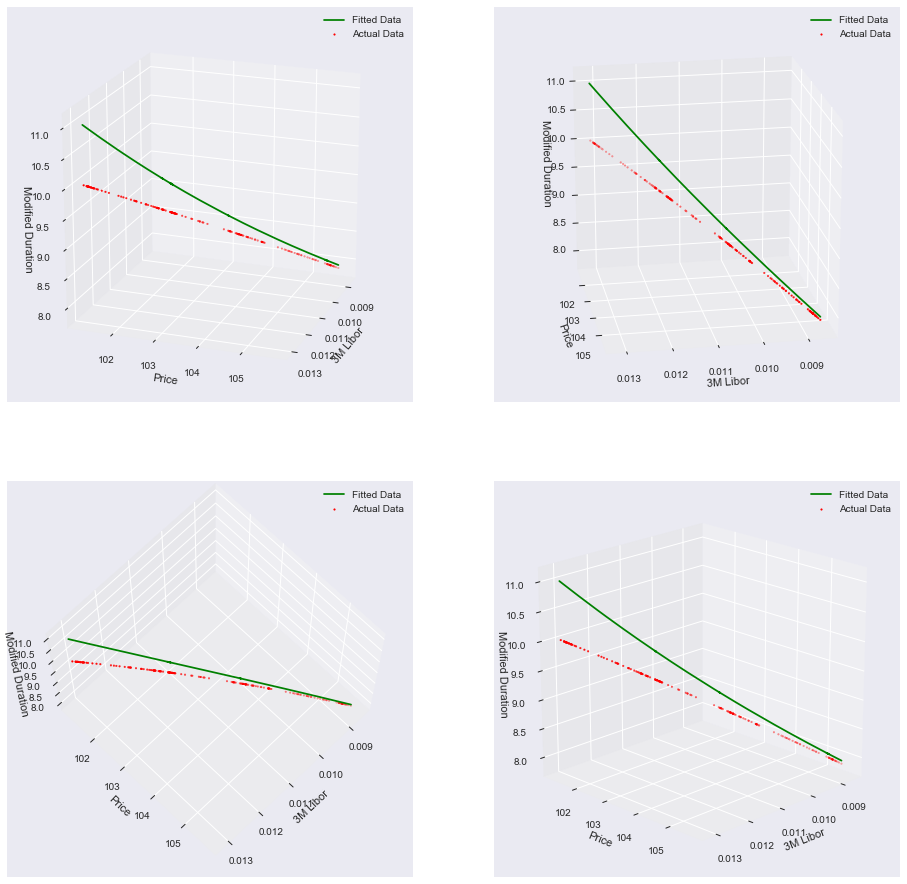

In [142]:
plotData(Ra_test, priceCa_test, duration_m_test, np.exp(fit))

**Observation: The order of 2 can fit the data well. The order of 3 polynomial fit the data terribly. This is due to overfitting in higher dimensional model. The exponential function form is also not a very good fit to the data**

## 1.4. Conclusion

We explored the possible function form for relationship $Duration = f(Price, Rate)$, and found that the low order polynomial could fit the data well. Higher order polynomial and exponential form face the issue of overfitting

# 2. Function Form with True Data

In next step, we will explore function form with true TBA/rates as well as issuance data. We will continue with models from simulated data first and experiment other possible function forms that fit the true data well.